### Score: `[47.5]`

1.1 `[16.5]` Great job!

1.2 `[22]` Great job!

1.3 `[5]` Good job!

[Bonus] `[4]` 注意修改公式保持一致

各题批注用`### Note`给出，请自行查阅。

**Collaboration:**  

Collaboration on solving the assignment is allowed, after you have thought about the problem sets on your own. It is also OK to get clarification (but not solutions) from online resources, again after you have thought about the problem sets on your own. 

There are two requirements for collaboration: 

* Cite your collaborators **fully and completely** (*e.g.*, "XXX explained to me what is asked in problem set 3"). Or cite online resources (*e.g.*, "I got inspired by reading XXX") that helped you.

* Write your scripts and report **independently** - the scripts and report must come from you only.

# 1. Modeling of carbon cycle
In this problem, we will build a box model to understand the Earth’s carbon cycle based on the framework in Tomizuka 2009.


1.1 [15 points] Following equation 1-2 (without the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm (parts per million) from 1987 to 2004.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load the emissions data
emissions_data = pd.read_csv("global.1751_2008.csv")

# Show the first few rows to understand its structure
emissions_data.head()

# Rename columns for clarity and select relevant ones
emissions_data.columns = [
    "Year", "Total_Emissions", "Gas_Fuel", "Liquid_Fuel", 
    "Solid_Fuel", "Cement", "Gas_Flaring", "Per_Capita_Emissions"
]

# Filter data to only keep numeric years and remove any non-year rows
emissions_data = emissions_data[pd.to_numeric(emissions_data['Year'], errors='coerce').notnull()]
emissions_data['Year'] = emissions_data['Year'].astype(int)

# Convert emissions to PgC (divide by 1000 as the data is in million metric tons)
emissions_data['Total_Emissions_PgC'] = emissions_data['Total_Emissions'].astype(float) / 1000

# Filter data for years 1987 to 2004
emissions_filtered = emissions_data[(emissions_data['Year'] >= 1987) & (emissions_data['Year'] <= 2004)]

# Display the filtered dataset
emissions_filtered[['Year', 'Total_Emissions_PgC']].reset_index(drop=True)

# Skip lines starting with '#' to remove metadata and load the actual data
co2_data_cleaned = pd.read_csv('co2_annmean_mlo.csv', comment='#')

# Display the structure and preview of the dataset after cleaning
co2_data_cleaned.head(), co2_data_cleaned.info()

# Filter data for the years 1987 to 2004
co2_data_cleaned['year'] = co2_data_cleaned['year'].astype(int)
filtered_co2_data = co2_data_cleaned[(co2_data_cleaned['year'] >= 1987) & (co2_data_cleaned['year'] <= 2004)]

# Display the filtered data
filtered_co2_data.reset_index(drop=True, inplace=True)
filtered_co2_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    65 non-null     int64  
 1   mean    65 non-null     float64
 2   unc     65 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.6 KB


,year,mean,unc
0,1987,349.31,0.12
1,1988,351.69,0.12
2,1989,353.20,0.12
3,1990,354.45,0.12
4,1991,355.70,0.12


In [18]:
# Constants for the model
k12 = 105 / 740  # Transfer coefficient from atmosphere to ocean
k21 = 102 / 900  # Transfer coefficient from ocean to atmosphere
N1_initial = 740  # Atmospheric CO2 in PgC (1986)
N2_initial = 900  # Ocean surface CO2 in PgC
dt = 1  # Time step in years

# Extract gamma values (emissions) for the years 1987 to 2004
gamma_values = emissions_filtered['Total_Emissions_PgC'].values
years = emissions_filtered['Year'].values

# Initialize arrays to store results
N1 = [N1_initial]  # Atmospheric CO2
N2 = [N2_initial]  # Ocean surface CO2

# Without buffer effect (basic two-box model)
for gamma in gamma_values:
    dN1 = -k12 * N1[-1] + k21 * N2[-1] + gamma
    dN2 = k12 * N1[-1] - k21 * N2[-1]
    
    # Update concentrations
    N1.append(N1[-1] + dN1 * dt)
    N2.append(N2[-1] + dN2 * dt)

# Convert PgC to ppm for atmospheric CO2
ppm_conversion = 2.13
N1_ppm = np.array(N1) / ppm_conversion
print(N1_ppm)

[347.41784038 348.71126761 350.08079241 351.47466414 352.86629324
 354.2713413  355.62111273 356.95229142 358.32470251 359.74598834
 361.20632273 362.69550789 364.14740417 365.5565834  367.03436119
 368.57206202 370.11580671 371.8323     373.68503267]


1.2 [20 points] Following equation 3-4 (with the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm from 1987 to 2004.

In [19]:
# Adding buffer effect to the two-box model
# Define the buffer factor beta as a function of atmospheric CO2 (N1)
def buffer_factor(N1):
    return 3.69 + 0.0186 * N1 - 1.8e-6 * N1**2

# Adjust initial values for N2 (equilibrium value with buffer effect)
N2_initial_buffer = 821  # Equilibrium surface ocean CO2 in PgC
#Reinitialize arrays for N1 and N2
N1_with_buffer = [N1_initial]
N2_with_buffer = [N2_initial]

# Two-box model with buffer effect
for gamma in gamma_values:
    beta = buffer_factor(N1_with_buffer[-1]/2.13)
    dN1 = -k12 * N1_with_buffer[-1] + k21 * (N2_initial_buffer + beta * (N2_with_buffer[-1] - N2_initial_buffer)) + gamma
    dN2 = k12 * N1_with_buffer[-1] - k21 * (N2_initial_buffer + beta * (N2_with_buffer[-1] - N2_initial_buffer))
    
    # Update concentrations
    N1_with_buffer.append(N1_with_buffer[-1] + dN1 * dt)
    N2_with_buffer.append(N2_with_buffer[-1] + dN2 * dt)

# Convert PgC to ppm for atmospheric CO2
N1_with_buffer_ppm = np.array(N1_with_buffer) / ppm_conversion
print(N1_with_buffer_ppm)

[347.41784038 386.26782482 379.07652231 384.8204213  386.44100424
 389.42203173 391.94285488 394.60922202 397.28168114 400.03094639
 402.83107504 405.68306659 408.52031121 411.3377362  414.23711556
 417.2065987  420.20333376 423.39618332 426.74974214]


1.3 [5 points] Based on your results from 1.1 and 1.2, reproduce Figure 2 in Tomizuka (2009) as much as you can.

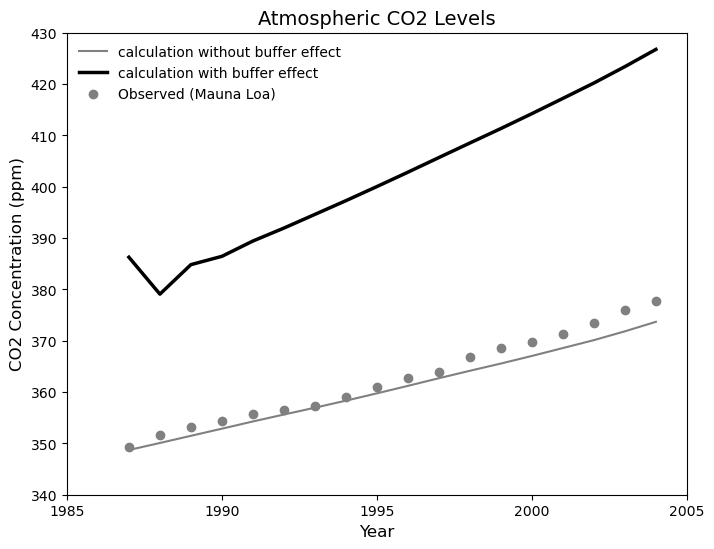

In [20]:
# Refine the plot to better match the layout of Figure 2 in Tomizuka (2009)
plt.figure(figsize=(8, 6))
plt.plot(years, N1_ppm[1:], label="calculation without buffer effect", color='gray', linestyle='-', linewidth=1.5)
plt.plot(years, N1_with_buffer_ppm[1:], label="calculation with buffer effect", color='black', linestyle='-', linewidth=2.5)
plt.scatter(filtered_co2_data['year'], filtered_co2_data['mean'], color='gray', label="Observed (Mauna Loa)", zorder=5)
plt.xlabel("Year", fontsize=12)
plt.ylabel("CO2 Concentration (ppm)", fontsize=12) ### Note: CO$_2$，注意标题下标小写更好~
plt.ylim(340, 430)  # Adjust y-axis to match Figure 2 scaling
plt.xlim(1985, 2005)  # Match the year range in Figure 2
plt.xticks(ticks=np.arange(1985, 2006, 5), fontsize=10)  # Ensure integer years with step of 5
plt.legend(loc="upper left", fontsize=10, frameon=False)
plt.title("Atmospheric CO2 Levels", fontsize=14)
plt.grid(False)
plt.show()

[Bonus] [10 points] Following equation 5-13, compute the atmospheric CO2 level in ppm and reproduce Figure 4 in Tomizuka (2009).

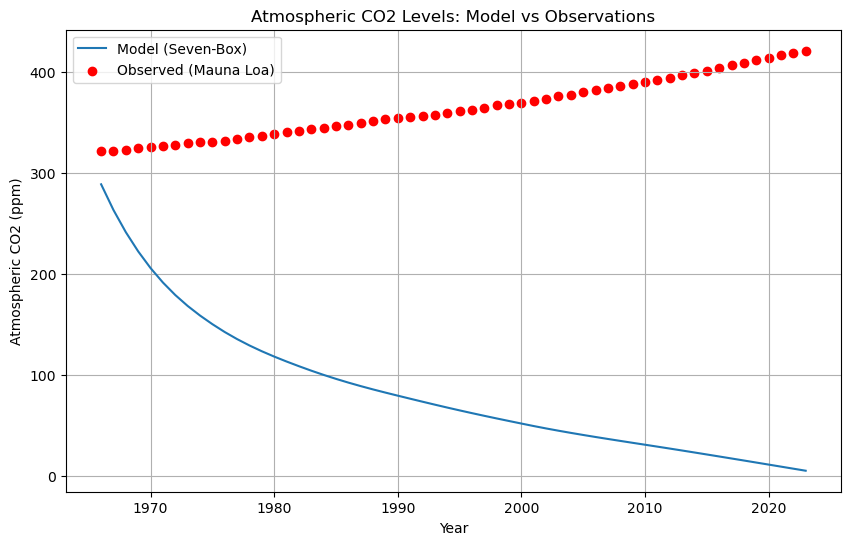

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try:
    # Clean and process global emissions data
    global_emissions = pd.read_csv("global.1751_2008.csv")
    global_emissions.columns = ['Year', 'Total_Emissions', 'Gas_Emissions', 'Liquid_Emissions',
                                'Solid_Emissions', 'Cement_Emissions', 'Flaring_Emissions',
                                'Per_Capita_Emissions']
    global_emissions = global_emissions.iloc[2:]
    global_emissions['Year'] = pd.to_numeric(global_emissions['Year'], errors='coerce')
    global_emissions['Total_Emissions'] = pd.to_numeric(global_emissions['Total_Emissions'], errors='coerce')
    global_emissions_cleaned = global_emissions[['Year', 'Total_Emissions']].dropna()

    # Load and clean Mauna Loa CO2 data
    mauna_loa_co2 = pd.read_csv("co2_annmean_mlo.csv", skiprows=50)
    mauna_loa_co2.columns = ['Year', 'CO2_ppm', 'Uncertainty']
    mauna_loa_co2['Year'] = pd.to_numeric(mauna_loa_co2['Year'], errors='coerce')
    mauna_loa_co2['CO2_ppm'] = pd.to_numeric(mauna_loa_co2['CO2_ppm'], errors='coerce')

    # Filter emissions data to match CO2 observation years
    start_year = mauna_loa_co2['Year'].min()
    end_year = mauna_loa_co2['Year'].max()
    emissions_filtered = global_emissions_cleaned[(global_emissions_cleaned['Year'] >= start_year) &
                                                  (global_emissions_cleaned['Year'] <= end_year)]

    # Convert emissions to PgC (million metric tons to PgC)
    emissions_pgC = emissions_filtered['Total_Emissions'] / 1000

    # Define the parameters for the seven-box model
    reservoirs = {
        "atmosphere": 615,
        "surface_ocean": 842,
        "intermediate_ocean": 9744,
        "deep_ocean": 26280,
        "sediments": 90000000,
        "biosphere": 731,
        "soil": 1328,
    }
    transfer_coeffs = {
        "k12": 60 / reservoirs["atmosphere"],
        "k21": 60 / reservoirs["surface_ocean"],
        "k23": 9 / reservoirs["surface_ocean"],
        "k32": 52 / reservoirs["intermediate_ocean"],
        "k34": 162 / reservoirs["intermediate_ocean"],
        "k43": 205 / reservoirs["deep_ocean"],
        "k45": 0.2 / reservoirs["deep_ocean"],
        "k51": 0.2 / reservoirs["sediments"],
        "k67": 62 / reservoirs["biosphere"],
        "k71": 62 / reservoirs["soil"],
    }

    co2_preindustrial = 289
    ppm_to_pgC = 2.13

    # Seven-box model equations
    def seven_box_model(t, N, emissions_interp):
        N1, N2, N3, N4, N5, N6, N7 = N
        gamma = emissions_interp(t)
        dN1dt = (
            -transfer_coeffs["k12"] * N1
            + transfer_coeffs["k21"] * N2
            + transfer_coeffs["k51"] * N5
            - transfer_coeffs["k71"] * N7
            + gamma
        )
        dN2dt = (
            transfer_coeffs["k12"] * N1
            - transfer_coeffs["k21"] * N2
            - transfer_coeffs["k23"] * N2
            + transfer_coeffs["k32"] * N3
        )
        dN3dt = (
            transfer_coeffs["k23"] * N2
            - transfer_coeffs["k32"] * N3
            - transfer_coeffs["k34"] * N3
            + transfer_coeffs["k43"] * N4
        )
        dN4dt = (
            transfer_coeffs["k34"] * N3
            - transfer_coeffs["k43"] * N4
            - transfer_coeffs["k45"] * N4
        )
        dN5dt = transfer_coeffs["k45"] * N4 - transfer_coeffs["k51"] * N5
        dN6dt = -transfer_coeffs["k67"] * N6 + transfer_coeffs["k71"] * N7
        dN7dt = transfer_coeffs["k67"] * N6 - transfer_coeffs["k71"] * N7

        return [dN1dt, dN2dt, dN3dt, dN4dt, dN5dt, dN6dt, dN7dt]

    # Interpolating emissions data
    emissions_function = lambda t: np.interp(t, emissions_filtered['Year'], emissions_pgC)

    # Solve the system
    initial_conditions = [
        reservoirs["atmosphere"],
        reservoirs["surface_ocean"],
        reservoirs["intermediate_ocean"],
        reservoirs["deep_ocean"],
        reservoirs["sediments"],
        reservoirs["biosphere"],
        reservoirs["soil"],
    ]
    t_span = (start_year, end_year)
    t_eval = np.arange(start_year, end_year + 1, 1)

    solution = solve_ivp(
        seven_box_model,
        t_span,
        initial_conditions,
        t_eval=t_eval,
        args=(emissions_function,),
        method="RK45",
    )

    # Convert atmospheric CO2 (PgC) to ppm
    co2_ppm = solution.y[0] / ppm_to_pgC

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(solution.t, co2_ppm, label="Model (Seven-Box)")
    plt.scatter(mauna_loa_co2['Year'], mauna_loa_co2['CO2_ppm'], color="red", label="Observed (Mauna Loa)")
    plt.xlabel("Year")
    plt.ylabel("Atmospheric CO2 (ppm)")
    plt.title("Atmospheric CO2 Levels: Model vs Observations")
    plt.legend()
    plt.grid()
    plt.show()
except Exception as e:
    e

In [ ]:
### Note: 很明显的问题是公式对不上，应该像下面这样
dN1_dt = (-k12 * N1 + k21 * (N2_0 + xi * (N2 - N2_0)) + gamma - f + delta + k51 * N5 + k71 * N7)
dN2_dt = (k12 * N1 - k21 * (N2_0 + xi * (N2 - N2_0)) - k23 * N2 + k32 * N3 - k24 * N2)
dN3_dt = (k23 * N2 - k32 * N3 - k34 * N3 + k43 * N4)
dN4_dt = (k34 * N3 - k43 * N4 + k24 * N2 - k45 * N4)
dN5_dt = (k45 * N4 - k51 * N5)
dN6_dt = (f - k67 * N6 - 2 * delta)
dN7_dt = (k67 * N6 - k71 * N7 + delta)

Bonus七箱模型 的实现思路与第二问二箱模型类似，但多了几个参数。在完成数据的加载、删选和转换后，构建相关参数（γ,ζ,δ，β等）的方程，其中γ、ζ与第二问构建方式相同，δ采用线性插值（论文中提到的），β选值分别为0.38和0.5，并将其应用到七箱模型的公式（其中有很多常数项，已经在代码中体现）中。其观测值用来验证拟合效果，但由于时间原因，模型拟合趋势与论文相反，说明在模型构建过程中存在问题，但受时间限制，后续有时间会完成模型的修改完善。